📂 Loading data from: /Users/qiunan/MAP_Hackathon_2026_G4/data/processed/nhanes_2017_2018_filtered.pkl
   Initial Shape: (2375, 2796)

🧹 Step 1: Cleaning Special Values (77/99 -> NaN)...

🧮 Step 2: Calculating All Derived Metrics (Pre-Imputation)...
   - PhenoAge Calculated. Mean: 52.02 years
   - PhenoAgeAccel Calculated. Mean (should be ~0): 0.0000
   - Correlation (Age vs PhenoAge): r = 0.921

📈 Visualizing PhenoAge Distributions...


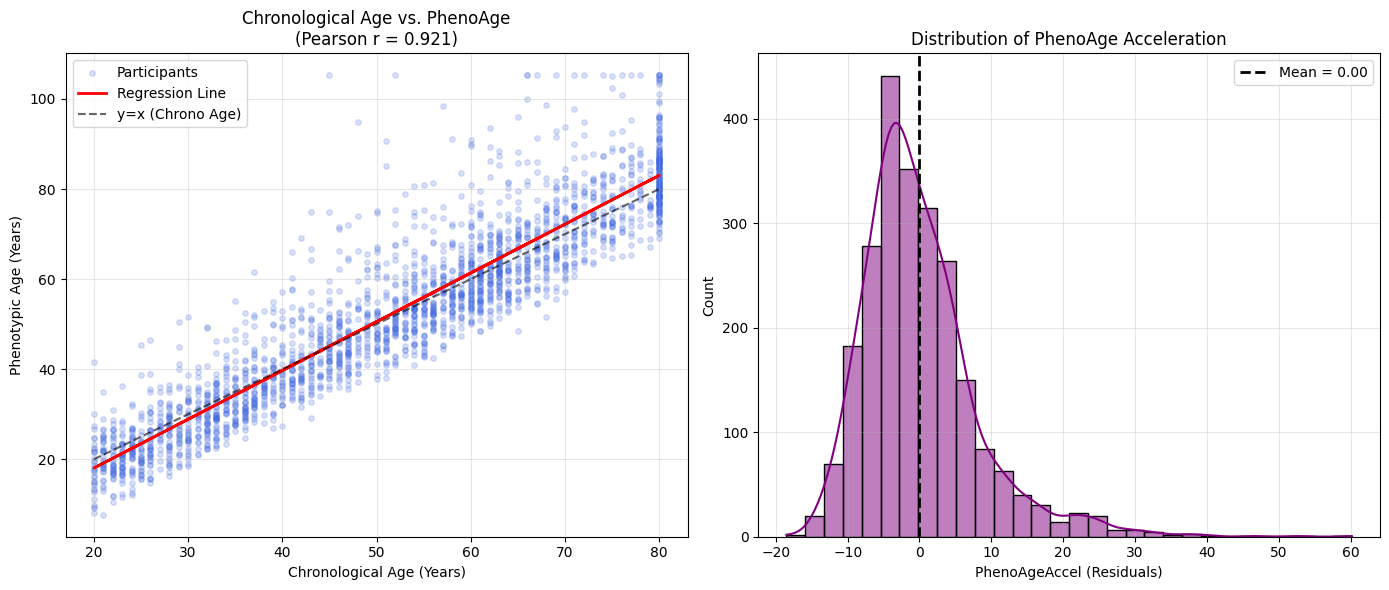

   - Derived metrics calculation complete (NaNs present where raw data was missing).
   - Shape after metrics: (2375, 2806)

🧹 Step 3: Removing empty columns before MICE...

🧩 Step 4: MICE Imputation on ALL data (Raw + Derived)...
   - Imputing 2656 numeric variables...
[IterativeImputer] Completing matrix with shape (2375, 2656)
[IterativeImputer] Change: 636060052.2424406, scaled tolerance: 6666667.008 
[IterativeImputer] Change: 4682175062.899442, scaled tolerance: 6666667.008 
[IterativeImputer] Change: 6017119339.107236, scaled tolerance: 6666667.008 
[IterativeImputer] Change: 6022076091.8502655, scaled tolerance: 6666667.008 
[IterativeImputer] Change: 6673851560.9237, scaled tolerance: 6666667.008 
   ✅ Imputation Complete. Total Missing: 0

📊 Step 5: Log Transformation & Saving...
   - Log-transformed 1247 variables.
   Saved to: /Users/qiunan/MAP_Hackathon_2026_G4/data/processed/nhanes_processed_final.pkl
   Final Shape: (2375, 4053)
🎉 Done!


In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# MICE 相关库
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. Config & Load Data
# ==========================================
PROJECT_ROOT = os.path.dirname(os.getcwd())
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
input_pkl_path = os.path.join(PROCESSED_DIR, "nhanes_2017_2018_filtered.pkl")

print(f"📂 Loading data from: {input_pkl_path}")
if not os.path.exists(input_pkl_path):
    raise FileNotFoundError("Run 02_Filtered.ipynb first!")

df = pd.read_pickle(input_pkl_path)
print(f"   Initial Shape: {df.shape}")

# ==========================================
# 2. Initial Cleaning (Crucial Before Calculation)
# ==========================================
print("\n🧹 Step 1: Cleaning Special Values (77/99 -> NaN)...")
if "SLD012" in df.columns:
    df["SLD012"] = df["SLD012"].replace({77: np.nan, 99: np.nan})

# ==========================================
# 3. Calculate ALL Derived Metrics (Before Imputation)
# ==========================================
print("\n🧮 Step 2: Calculating All Derived Metrics (Pre-Imputation)...")

# --- A. PhenoAge & Accel (Based on Complete Cases from Step 02) ---
try:
    # 1. Prepare Variables (Levine 2018 units)
    age = df["RIDAGEYR"]
    alb = df["LBXSAL"] * 10          # g/dL -> g/L
    cre = df["LBXSCR"] * 88.4        # mg/dL -> umol/L
    glu = df["LBXGLU"] / 18.016      # mg/dL -> mmol/L
    # Log CRP (clip to avoid log(0))
    crp = np.log((df["LBXHSCRP"] / 10).clip(lower=0.001)) 
    lymph = df["LBXLYPCT"]
    mcv = df["LBXMCVSI"]
    rdw = df["LBXRDW"]
    alp = df["LBXSAPSI"]
    wbc = df["LBXWBCSI"]

    # 2. Calculate PhenoAge
    xb = (-19.9067 - 0.0336*alb + 0.0095*cre + 0.1953*glu + 0.0954*crp 
          - 0.0120*lymph + 0.0268*mcv + 0.3306*rdw + 0.00188*alp + 0.0554*wbc + 0.0804*age)
    
    gamma = 0.0076927
    m_risk = 1 - np.exp(-np.exp(xb) * (np.exp(120 * gamma) - 1) / gamma)
    df["PhenoAge"] = 141.50225 + np.log(-0.00553 * np.log(1 - m_risk.clip(upper=0.999))) / 0.090165
    
    print(f"   - PhenoAge Calculated. Mean: {df['PhenoAge'].mean():.2f} years")

    # 3. Calculate PhenoAgeAccel (Residuals)
    # Only calculate for rows where PhenoAge is not null
    valid_idx = df.dropna(subset=["PhenoAge", "RIDAGEYR"]).index
    
    if len(valid_idx) > 0:
        X_age = df.loc[valid_idx, ["RIDAGEYR"]]
        y_pheno = df.loc[valid_idx, "PhenoAge"]
        
        model = LinearRegression()
        model.fit(X_age, y_pheno)
        
        # Calculate Residuals: Actual PhenoAge - Predicted PhenoAge based on Chronological Age
        df.loc[valid_idx, "PhenoAgeAccel"] = y_pheno - model.predict(X_age)
        
        # Calculate Stats
        mean_accel = df.loc[valid_idx, "PhenoAgeAccel"].mean()
        corr_r = X_age["RIDAGEYR"].corr(y_pheno) # Pearson Correlation
        
        print(f"   - PhenoAgeAccel Calculated. Mean (should be ~0): {mean_accel:.4f}")
        print(f"   - Correlation (Age vs PhenoAge): r = {corr_r:.3f}")

        # [NEW] Visualizations with Correlation
        print("\n📈 Visualizing PhenoAge Distributions...")
        plt.figure(figsize=(14, 6))

        # Plot 1: Chronological Age vs PhenoAge
        plt.subplot(1, 2, 1)
        plt.scatter(df.loc[valid_idx, "RIDAGEYR"], df.loc[valid_idx, "PhenoAge"], 
                    alpha=0.2, s=15, color='royalblue', label='Participants')
        
        # Regression line
        plt.plot(X_age, model.predict(X_age), color='red', linewidth=2, label='Regression Line')
        
        # Reference y=x
        plt.plot([20, 80], [20, 80], color='black', linestyle='--', alpha=0.6, label='y=x (Chrono Age)')
        
        # Add Title with Correlation
        plt.title(f"Chronological Age vs. PhenoAge\n(Pearson r = {corr_r:.3f})", fontsize=12)
        plt.xlabel("Chronological Age (Years)")
        plt.ylabel("Phenotypic Age (Years)")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # Plot 2: Distribution of PhenoAgeAccel
        plt.subplot(1, 2, 2)
        sns.histplot(df.loc[valid_idx, "PhenoAgeAccel"], kde=True, color='purple', bins=30)
        plt.axvline(0, color='black', linestyle='--', linewidth=2, label=f'Mean = {mean_accel:.2f}')
        plt.title(f"Distribution of PhenoAge Acceleration", fontsize=12)
        plt.xlabel("PhenoAgeAccel (Residuals)")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

except KeyError as e:
    print(f"❌ Error calculating PhenoAge: Missing variable {e}")

# --- B. Other Metrics (Derived from potentially missing raw data) ---

# 1. eGFR
def calculate_egfr(row):
    if pd.isna(row.get('LBXSCR')) or pd.isna(row.get('RIDAGEYR')) or pd.isna(row.get('RIAGENDR')): return np.nan
    scr = row['LBXSCR']
    age = row['RIDAGEYR']
    is_female = (row['RIAGENDR'] == 2)
    kappa = 0.7 if is_female else 0.9
    alpha = -0.329 if is_female else -0.411
    scr_div_kappa = scr / kappa
    egfr = 141 * (min(scr_div_kappa, 1) ** alpha) * (max(scr_div_kappa, 1) ** -1.209) * (0.993 ** age)
    if is_female: egfr *= 1.018
    return egfr

if 'LBXSCR' in df.columns:
    df['eGFR'] = df.apply(calculate_egfr, axis=1)

# 2. Lipid Ratios
if 'LBXTC' in df.columns and 'LBDHDD' in df.columns:
    df['TC_HDL_ratio'] = df['LBXTC'] / df['LBDHDD']
    df['non_HDL'] = df['LBXTC'] - df['LBDHDD']

if 'LBDLDL' in df.columns and 'LBDHDD' in df.columns:
    df['LDL_HDL_ratio'] = df['LBDLDL'] / df['LBDHDD']

# 3. HOMA-IR (Uses Insulin which may be missing, will be NaN here)
if 'LBXIN' in df.columns and 'LBXGLU' in df.columns:
    df['HOMA_IR'] = (df['LBXIN'] * df['LBXGLU']) / 405

# 4. FIB-4
if all(col in df.columns for col in ['RIDAGEYR', 'LBXSASSI', 'LBXPLTSI', 'LBXSATSI']):
    df['FIB4'] = (df['RIDAGEYR'] * df['LBXSASSI']) / (df['LBXPLTSI'] * np.sqrt(df['LBXSATSI']))

# 5. Others
if 'LBXSASSI' in df.columns and 'LBXSATSI' in df.columns:
    df['AST_ALT_ratio'] = df['LBXSASSI'] / df['LBXSATSI']
if 'URXUMA' in df.columns and 'URXUCR' in df.columns:
    df['ACR'] = (df['URXUMA'] / df['URXUCR']) * 100

print(f"   - Derived metrics calculation complete (NaNs present where raw data was missing).")
print(f"   - Shape after metrics: {df.shape}")

# ==========================================
# 4. Pre-Imputation Cleanup
# ==========================================
print("\n🧹 Step 3: Removing empty columns before MICE...")
# Important: If a derived metric is all NaNs (e.g. insulin missing for everyone), drop it.
empty_cols = df.columns[df.isnull().all()]
if len(empty_cols) > 0:
    df.drop(columns=empty_cols, inplace=True)
    print(f"   - Dropped {len(empty_cols)} completely empty columns.")

# ==========================================
# 5. Robust MICE Imputation
# ==========================================
print("\n🧩 Step 4: MICE Imputation on ALL data (Raw + Derived)...")

numeric_cols = df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# A. Categorical -> Mode
if len(categorical_cols) > 0:
    imp_cat = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imp_cat.fit_transform(df[categorical_cols])

# B. Numeric -> MICE (ExtraTrees)
# Imputes both original vars (e.g., LBXIN) and derived vars (e.g., HOMA-IR)
print(f"   - Imputing {len(numeric_cols)} numeric variables...")
mice_imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, n_jobs=-1, random_state=42),
    n_nearest_features=20, # Keep 20 features for speed and stability
    max_iter=5,
    random_state=42,
    sample_posterior=False,
    min_value=0,
    verbose=1
)

df_numeric_imputed = pd.DataFrame(
    mice_imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols,
    index=df.index
)
df[numeric_cols] = df_numeric_imputed

print(f"   ✅ Imputation Complete. Total Missing: {df.isnull().sum().sum()}")

# ==========================================
# 6. Log Transform & Save
# ==========================================
print("\n📊 Step 5: Log Transformation & Saving...")

skewness = df[numeric_cols].apply(lambda x: skew(x))
high_skew_cols = skewness[abs(skewness) > 2].index.tolist()
exclude_from_log = ['SEQN', 'RIDAGEYR', 'PhenoAge', 'PhenoAgeAccel'] + \
                   [c for c in high_skew_cols if df[c].min() < 0]
cols_to_log = [c for c in high_skew_cols if c not in exclude_from_log]

# Use concat
new_log_cols = pd.DataFrame()
for col in cols_to_log:
    new_log_cols[f"{col}_log"] = np.log1p(df[col])

df = pd.concat([df, new_log_cols], axis=1)
print(f"   - Log-transformed {len(cols_to_log)} variables.")

# Save
final_pkl_path = os.path.join(PROCESSED_DIR, "nhanes_processed_final.pkl")
final_csv_path = os.path.join(PROCESSED_DIR, "nhanes_processed_final.csv")
df.to_pickle(final_pkl_path)
df.to_csv(final_csv_path, index=False)

print(f"   Saved to: {final_pkl_path}")
print(f"   Final Shape: {df.shape}")
print("🎉 Done!")